In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

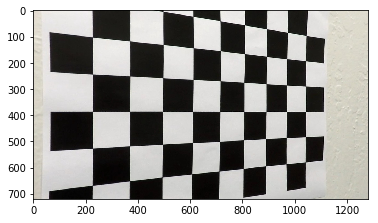

In [58]:
class Camera:
    def __init__(self, path_to_imgs, chessboard_dim):
        self.isCalibrated = False
        images = glob.glob(path_to_imgs)
        obj_pts = np.zeros((chessboard_dim[0] * chessboard_dim[1], 3), np.float32)
        obj_pts[:, :2] = np.mgrid[0 : chessboard_dim[0], 0 : chessboard_dim[1]].T.reshape(-1, 2)
        
        obj_set = []
        img_set = []
        for image in images:
            gray = cv2.cvtColor(mpimg.imread(image), cv2.COLOR_RGB2GRAY)
            ret, img_pts = cv2.findChessboardCorners(gray, chessboard_dim, None)
            if ret:
                img_set.append(img_pts)
                obj_set.append(obj_pts)
        if img_set:
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_set, img_set, gray.shape[::-1], None, None)
            if ret:
                self.isCalibrated = True
                self.__mtx = mtx
                self.__dist = dist
                self.__cb_dir = path_to_imgs
                self.__cb_dim = chessboard_dim
    def correctDistortion(self, img):
        if self.isCalibrated:
            return cv2.undistort(img, self.__mtx, self.__dist)
        else:
            return np.array([])
    def showTestImage(self):
        undist = self.correctDistortion(mpimg.imread(glob.glob(self.__cb_dir)[0]))
        if undist.size:
            plt.imshow(undist)
            plt.savefig("./output_images/01_rawCamera_chessboard_undistorted.png")
        
my_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
my_camera.showTestImage()


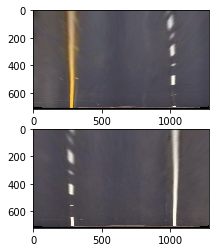

In [66]:
class MountingPerspective():
    def manual_setup(self):
        img = mpimg.imread("./test_images/straight_lines1.jpg")
        real_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
        undist = real_camera.correctDistortion(img)
        # this is supposedly done offline.
        plt.imshow(undist)
    def __init__(self):
        src = np.float32([
            [282, 670],
            [595, 451],
            [690, 451],
            [1034, 670],
        ])
        dst = np.float32([
            [282, 700],
            [282, 100],
            [1034, 100],
            [1034, 700],
        ])
        self.__M = cv2.getPerspectiveTransform(src, dst)
        self.__Minv = cv2.getPerspectiveTransform(dst, src)
    def correctPerspective(self, img):
        dim = img.shape[:2]
        return cv2.warpPerspective(img, self.__M, dim[::-1], flags = cv2.INTER_LINEAR)
    def reversePerspective(self, img):
        return cv2.warpPerspective(img, self.__Minv, dim[::-1], flags = cv2.INTER_LINEAR)

# %matplotlib notebook
# my_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
my_mounting = MountingPerspective()
# mounting.manual_setup()

img = mpimg.imread("./test_images/straight_lines1.jpg")
undist = my_camera.correctDistortion(img)
birdeye1 = my_mounting.correctPerspective(undist)

img = mpimg.imread("./test_images/straight_lines2.jpg")
undist = my_camera.correctDistortion(img)
birdeye2 = my_mounting.correctPerspective(undist)

h, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(birdeye1)
ax2.imshow(birdeye2)
plt.savefig("./output_images/02_mountedCamera_straightlines_undistorted_and_perspective.png")

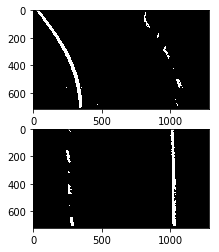

In [78]:
class LaneActivatedImage():
    def __init__(self, img):
        self.__image = np.copy(img)
    def getActivatedCopy(self):
        sobel_kernel = 9
        thresh_i = 20
        thresh_t = np.pi / 4
        thresh_s = 170
        hls = cv2.cvtColor(self.__image, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        divx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        divy = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        divi = (divx ** 2 + divy ** 2) ** 0.5
        divi = 255 * divi / np.max(divi)
        divt = np.abs(np.arctan2(divy, divx))
        binary_output = np.zeros_like(l_channel)
        binary_output[((divi > thresh_i) & (divt < thresh_t)) | (s_channel > thresh_s)] = 1
        # 6) Return this mask as your binary_output image
        # binary_output = np.copy(img) # Remove this line
        return binary_output

img = mpimg.imread("./test_images/test1.jpg")
undist = my_camera.correctDistortion(img)
birdeye1 = my_mounting.correctPerspective(undist)
img = mpimg.imread("./test_images/test2.jpg")
undist = my_camera.correctDistortion(img)
birdeye1 = my_mounting.correctPerspective(undist)

activated1 = LaneActivatedImage(birdeye1).getActivatedCopy()
activated2 = LaneActivatedImage(birdeye2).getActivatedCopy()
h, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(activated1, cmap = 'gray')
ax2.imshow(activated2, cmap = 'gray')
plt.savefig("./output_images/03_warped_activated_lanepixels.png")

In [96]:
class Line():
    def __init__(self, img_shape, res_mpp, side = 'left'):
        self.lifelines = 0
        self.nmaxlines = 5
        self.y_eval = np.linspace(0, img_shape[0] - 1, img_shape[0])
        self.x_eval = np.zeros_like(self.y_eval)
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = np.zeros_like(self.y_eval)
        #average x values of the fitted line over the last n iterations
        self.bestx = 0     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0, 0, 0])
        #average x values of the current fitted line
        self.currentx = 0
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0, 0, 0])  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 1 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        self.side = side
        self.margin = 100  # unit: pixel
        self.minpix = 400  # number of pixels required to start a polyfit
        self.mpp = (res_mpp[0], res_mpp[1])

    def discardLastTick(self):
        self.detected = False
        self.lifelines = max(0, self.lifelines - 1)
    def keepLastTick(self):
        self.detected = True
        self.recent_xfitted = (self.recent_xfitted * self.lifelines + self.x_eval) // (self.lifelines + 1)
        self.best_fit = np.polyfit(self.y_eval, self.recent_xfitted, 2)
        self.bestx = self.recent_xfitted[-1]
        self.lifelines = min(self.nmaxlines, self.lifelines + 1)
    def updateFromImage(self, binary_warped):
        if not self.lifelines:
            self.__createFromImage(binary_warped)
            return
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        fittedx = np.polyval(self.best_fit, nonzeroy)
        lane_inds = (nonzerox > fittedx - self.margin) & (nonzerox < fittedx + self.margin)
        if len(lane_inds) > self.minpix:
            self.detected = True
            self.current_fit = np.polyfit(nonzeroy[lane_inds], nonzerox[lane_inds], 2)
            self.x_eval = np.polyval(self.current_fit, self.y_eval)
            self.currentx = self.x_eval[-1]
        else:
            self.detected = False
    def __createFromImage(self, binary_warped):
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        if self.side == 'left':
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0] // nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = x_base
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_x_low = max(0, x_current - self.margin)
            win_x_high = min(binary_warped.shape[1], x_current + self.margin)

            good_inds = []
            tmp_x = 0
            for idx in range(len(nonzerox)):
                if (win_y_low <= nonzeroy[idx] < win_y_high) and (win_x_low < nonzerox[idx] < win_x_high):
                    good_inds.append(idx)
                    tmp_x += nonzerox[idx]
            lane_inds.append(list(good_inds))
            if len(good_inds) >= minpix:
                x_current = tmp_x // len(good_inds)
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
        if len(lane_inds) > self.minpix:
            self.detected = True
            self.current_fit = np.polyfit(nonzeroy[lane_inds], nonzerox[lane_inds], 2)
            self.x_eval = np.polyval(self.current_fit, self.y_eval)
            self.currentx = self.x_eval[-1]
        else:
            self.detected = False

left = Line(activated1.shape[:2], (3.7/700, 30/720), side = 'left')
left.updateFromImage(activated1)
left.keepLastTick()
right = Line(activated1.shape[:2], (3.7/700, 30/720), side = 'right')
right.updateFromImage(activated1)
right.keepLastTick()

print(left.bestx, right.bestx)

347.0 1074.0


In [97]:
class Lane():
    def __init__(self, img_shape, res_mpp):
        self.__left = Line(img_shape[:2], res_mpp, 'left')
        self.__right = Line(img_shape[:2], res_mpp, 'right')
        self.res_mpp = res_mpp
        self.__carPos = -1
    def updateFromImage(self, binary_warped):
        self.__left.updateFromImage(binary_warped)
        self.__right.updateFromImage(binary_warped)
        validatedLines = True
        if not (self.__left.detected and self.__right.detected):
            validatedLine = False
        del_x = self.__right.currentx - self.__right.currentx
        avg_x = (self.__right.currentx + self.__right.currentx) // 2
        del_c = self.__right.radius_of_curvature - self.__right.radius_of_curvature
        avg_c = (self.__right.radius_of_curvature + self.__right.radius_of_curvature) // 2
        if not (2.5 < del_x * self.res_mpp[0] < 4.5):
            validatedLines = False
        if not (0.7 < del_c * 0.5 / avg_c < 1.3):
            validatedLines = False
        if validatedLines:
            self.__left.keepLastTick()
            self.__right.keepLastTick()
            self.__carPos = avg_x
        else:
            self.__left.discardLastTick()
            self.__right.discardLastTick()
    def getCarPosInLane(self):
        return self.__carPos
lane= Lane(activated1.shape[:2], (3.7/700, 30/720))
lane.updateFromImage(activated1)
print(lane.getCarPosInLane())


-1
